In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#from helpers.plot_helpers import *
import cmocean
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 3

# Default matplotlib plotting parameters

In [2]:
import matplotlib
def default_rcParams(kw={}):
    '''
    Also matplotlib.rcParamsDefault contains the default values,
    but:
    - backend is changed
    - without plotting something as initialization,
    inline does not work
    '''
    plt.plot()
    plt.close()
    rcParams = matplotlib.rcParamsDefault.copy()
    
    # We do not change backend because it can break
    # inlining; Also, 'backend' key is broken and 
    # we cannot use pop method
    for key, val in rcParams.items():
        if key != 'backend':
            rcParams[key] = val

    matplotlib.rcParams.update({
        'font.family': 'MathJax_Main',
        'mathtext.fontset': 'cm',

        'figure.figsize': (4, 4),

        'figure.subplot.wspace': 0.3,
        
        'font.size': 14,
        #'axes.labelsize': 10,
        #'axes.titlesize': 12,
        #'xtick.labelsize': 10,
        #'ytick.labelsize': 10,
        #'legend.fontsize': 10,

        'axes.formatter.limits': (-2,3),
        'axes.formatter.use_mathtext': True,
        'axes.labelpad': 0,
        'axes.titlelocation' : 'center',
        
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })
    matplotlib.rcParams.update(**kw)

# SSH bias

In [3]:
def sort_longitude(x):
    x['lon'] = np.where(x['lon']>0, x['lon'], 360+x['lon'])
    x = x.sortby('lon')
    return x
def regrid_to_1x1(sst_R4, lon, lat):
    # Coarse with grid box 4x4
    sst_R1 = sst_R4.coarsen({'xh':4, 'yh':4}, boundary='trim').mean()
    # Rename coordinates:
    sst_R1 = sst_R1.rename({'xh':'lon', 'yh':'lat'})
    # Sort coordinates:
    sst_R1 = sort_longitude(sst_R1)
    # Interpolate to WOA grid
    sst_R1 = sst_R1.interp({'lon': lon, 'lat': lat})
    return sst_R1

In [4]:
# Read observation ssh data and select 3 years 1993-1995
from dask.diagnostics import ProgressBar
obs = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':1}).rename(
            {'longitude': 'lon', 'latitude': 'lat'}).adt

In [5]:
with ProgressBar():
    obs = obs.isel(time=slice(None,365*3)).std('time').coarsen({'lon':4,'lat':4}).mean().compute()

[########################################] | 100% Completed | 14.30 s


In [6]:
obs = sort_longitude(obs)

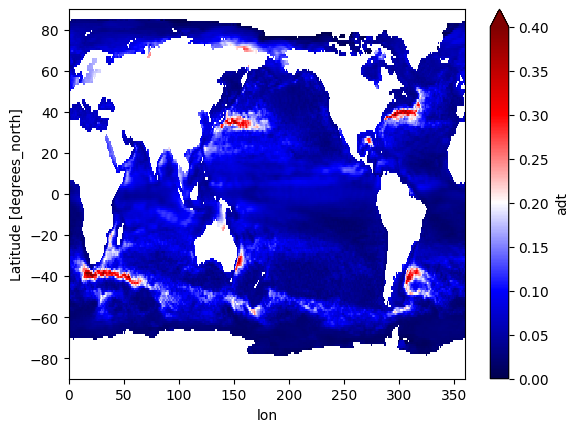

In [8]:
obs.plot(vmax=0.4, cmap='seismic')

In [9]:
om4 = xr.open_mfdataset('/scratch/pp2681/mom6/OM4_SIS2/unparameterized/output/*ocean_daily*', chunks={'time':1}).zos.isel(time=slice(-365*3,None))

In [10]:
with ProgressBar():
    om4 = regrid_to_1x1(om4.std('time'), obs.lon, obs.lat).compute()

[########################################] | 100% Completed | 26.92 s


In [11]:
zb20 = xr.open_mfdataset('/scratch/pp2681/mom6/OM4_SIS2/ZB20-Reynolds/output/*ocean_daily*', chunks={'time':1}).zos.isel(time=slice(-365*3,None))
with ProgressBar():
    zb20 = regrid_to_1x1(zb20.std('time'), obs.lon, obs.lat).compute()

[########################################] | 100% Completed | 21.06 s


In [12]:
ann_redline = xr.open_mfdataset('/scratch/pp2681/mom6/OM4_SIS2/ANN-redline/output/*ocean_daily*', chunks={'time':1}).zos.isel(time=slice(-365*3,None))
with ProgressBar():
    ann_redline = regrid_to_1x1(ann_redline.std('time'), obs.lon, obs.lat).compute()

[########################################] | 100% Completed | 23.11 s


In [13]:
ann_greenline = xr.open_mfdataset('/scratch/pp2681/mom6/OM4_SIS2/ANN-greenline/output/*ocean_daily*', chunks={'time':1}).zos.isel(time=slice(-365*3,None))
with ProgressBar():
    ann_greenline = regrid_to_1x1(ann_greenline.std('time'), obs.lon, obs.lat).compute()

[########################################] | 100% Completed | 20.00 s


Text(0.5, 1.0, 'Observations')

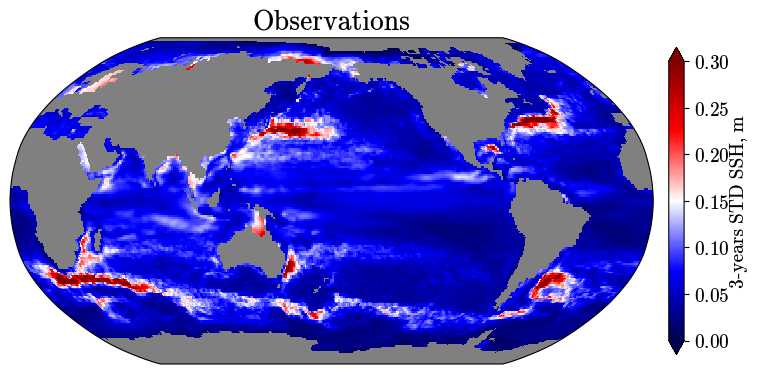

In [20]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = mpl.cm.get_cmap('seismic')
cmap.set_bad('gray')
data = obs
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=0.3, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='3-years STD SSH, m')
#cb.ax.set_yticks([-1, -0.5,0, 0.5,1])
plt.title('Observations', fontsize=20)

Text(0.5, 1.0, 'Unparameterized')

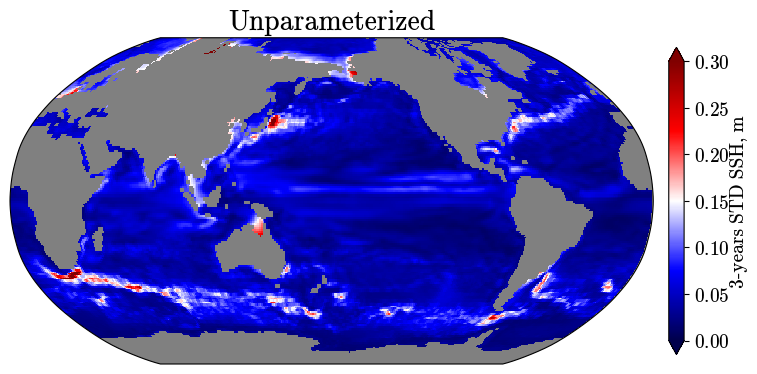

In [21]:
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = mpl.cm.get_cmap('seismic')
cmap.set_bad('gray')
data = om4
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=0.3, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='3-years STD SSH, m')
#cb.ax.set_yticks([-1, -0.5,0, 0.5,1])
plt.title('Unparameterized', fontsize=20)

Text(0.5, 1.0, 'ZB20-Reynolds')

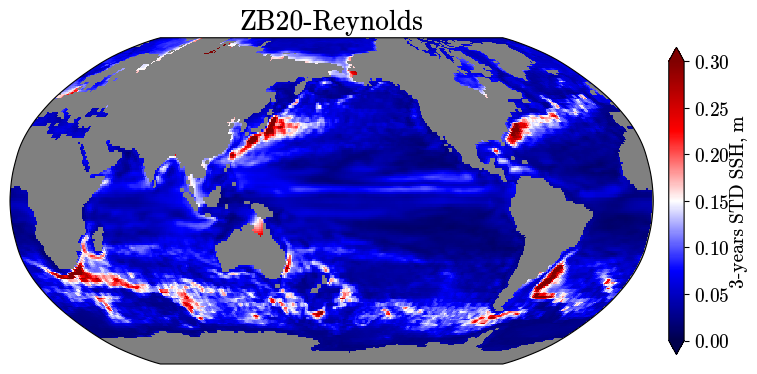

In [22]:
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = mpl.cm.get_cmap('seismic')
cmap.set_bad('gray')
data = zb20
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=0.3, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='3-years STD SSH, m')
#cb.ax.set_yticks([-1, -0.5,0, 0.5,1])
plt.title('ZB20-Reynolds', fontsize=20)

Text(0.5, 1.0, 'ANN with filters')

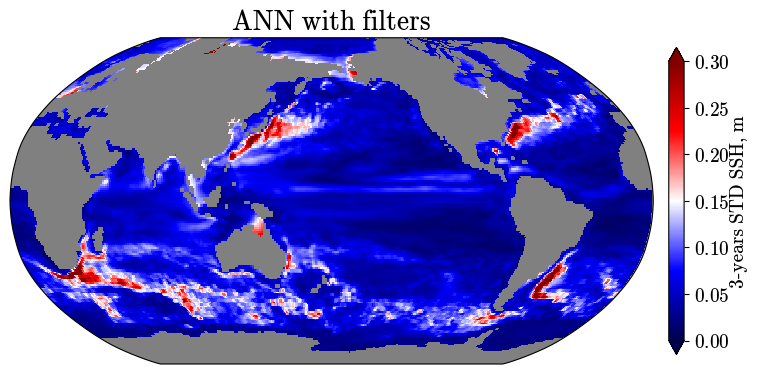

In [23]:
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = mpl.cm.get_cmap('seismic')
cmap.set_bad('gray')
data = ann_redline
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=0.3, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='3-years STD SSH, m')
#cb.ax.set_yticks([-1, -0.5,0, 0.5,1])
plt.title('ANN with filters', fontsize=20)

Text(0.5, 1.0, 'ANN without filters')

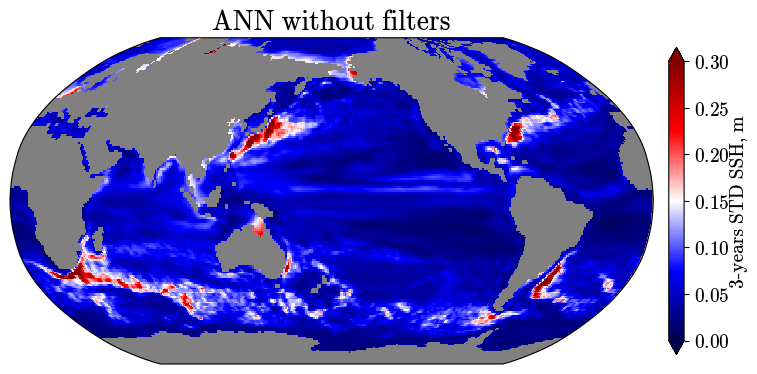

In [24]:
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = mpl.cm.get_cmap('seismic')
cmap.set_bad('gray')
data = ann_greenline
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=0.3, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='3-years STD SSH, m')
#cb.ax.set_yticks([-1, -0.5,0, 0.5,1])
plt.title('ANN without filters', fontsize=20)